In [9]:
from pathlib import Path
import pandas as pd
import numpy as np
results_folder = Path('/home/engaclew/neurogen/results/pyannote_metrics')

# Load f-score
fscore_lena = pd.read_csv(results_folder / 'its_eaf_an1' / 'fscore_30mn_clips.csv')
fscore_vtc = pd.read_csv(results_folder / 'vtc_eaf_an1' / 'fscore_30mn_clips.csv')
# Order
desired_order = ['low_risk', 'angelman_syndrome', 'fragile_x_syndrome', 'down_syndrome', 'autism_sibling']
fscore_lena['group_id'] = pd.Categorical(fscore_lena['group_id'], categories=desired_order, ordered=True)
fscore_vtc['group_id'] = pd.Categorical(fscore_vtc['group_id'], categories=desired_order, ordered=True)
fscore_lena = fscore_lena.sort_values('group_id')
fscore_vtc = fscore_vtc.sort_values('group_id')

print('Computing on %d chunks' % len(fscore_lena))
def compute_fscore(fscore_data):
    speakers = ['CHI', 'FEM', 'MAL', 'OCH']
    for speaker in speakers:
        # Precision = 1 if retrieved == 0 (all retrieved instances are correct since there was no retrieve instances
        fscore_data[f'precision_{speaker}'] = np.where(
            fscore_data[f'retrieved_{speaker}'] == 0,
            1,
            fscore_data[f'relevant retrieved_{speaker}'] / fscore_data[f'retrieved_{speaker}']
        )
    
        # Recall = 1 if relevant is 0 (all actual instances have been found since there was no example)
        fscore_data[f'recall_{speaker}'] = np.where(
            (fscore_data[f'relevant_{speaker}'] == 0),
            1,
            fscore_data[f'relevant retrieved_{speaker}'] / fscore_data[f'relevant_{speaker}']
        )
    
        # F-score calculation
        numerator = 2 * fscore_data[f'precision_{speaker}'] * fscore_data[f'recall_{speaker}']
        denominator = fscore_data[f'precision_{speaker}'] + fscore_data[f'recall_{speaker}']
        fscore_data[f'fscore_{speaker}'] = np.where(denominator != 0, numerator / denominator, 0)

    total_duration = (fscore_data['relevant_CHI'] + fscore_data['relevant_OCH'] + 
                 fscore_data['relevant_FEM'] + fscore_data['relevant_MAL'])

    total_global_duration = fscore_data[['relevant_CHI', 'relevant_OCH', 'relevant_FEM', 'relevant_MAL']].sum().sum()
    global_weights = {spk: fscore_data[f'relevant_{spk}'].sum() / total_global_duration for spk in speakers}
    print(f'Weights: {global_weights}')
    for metric in ['precision', 'recall', 'fscore']:
        fscore_data[f'weighted_{metric}'] = 100*sum(
                fscore_data[f'{metric}_{spk}'] * global_weights[spk] 
                for spk in speakers
            )
        fscore_data[metric] = 100 * fscore_data[[f'{metric}_{spk}' for spk in speakers]].mean(axis=1)
    return fscore_data

fscore_lena = compute_fscore(fscore_lena)
fscore_vtc = compute_fscore(fscore_vtc)


Computing on 26 chunks
Weights: {'CHI': 0.3179088973916934, 'FEM': 0.4123570276618445, 'MAL': 0.12804337740870694, 'OCH': 0.14169069753775512}
Weights: {'CHI': 0.3179088973916934, 'FEM': 0.4123570276618445, 'MAL': 0.12804337740870694, 'OCH': 0.14169069753775512}


/tmp/ipykernel_20058/1781966225.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lena_stats = fscore_lena.groupby('group_id')[metric].agg(['mean', 'std']).reset_index()
/tmp/ipykernel_20058/1781966225.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vtc_stats = fscore_vtc.groupby('group_id')[metric].agg(['mean', 'std']).reset_index()


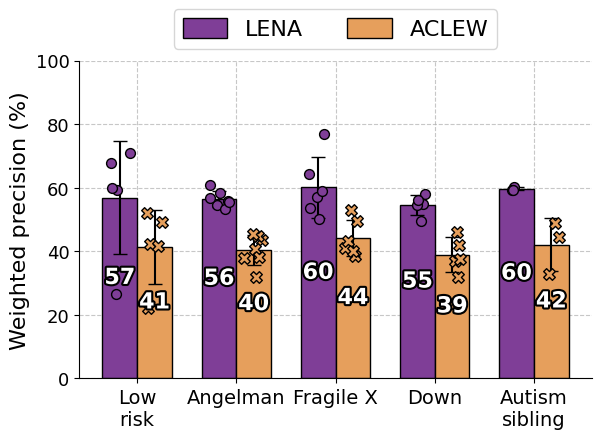

/tmp/ipykernel_20058/1781966225.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lena_stats = fscore_lena.groupby('group_id')[metric].agg(['mean', 'std']).reset_index()
/tmp/ipykernel_20058/1781966225.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vtc_stats = fscore_vtc.groupby('group_id')[metric].agg(['mean', 'std']).reset_index()


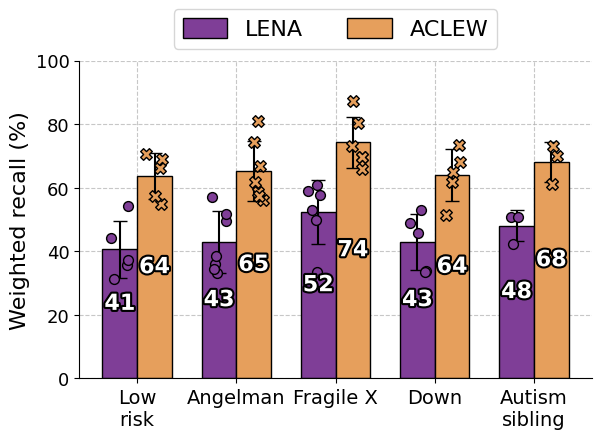

/tmp/ipykernel_20058/1781966225.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lena_stats = fscore_lena.groupby('group_id')[metric].agg(['mean', 'std']).reset_index()
/tmp/ipykernel_20058/1781966225.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vtc_stats = fscore_vtc.groupby('group_id')[metric].agg(['mean', 'std']).reset_index()


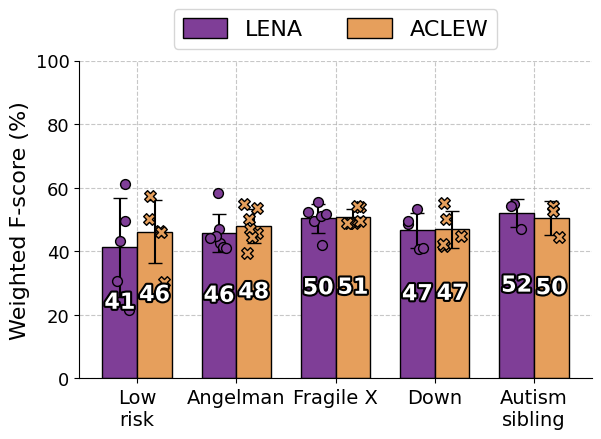

In [10]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.patheffects as path_effects

matplotlib.rcParams.update({
    'font.size': 16, 
    'legend.handleheight': 1, 
    'hatch.linewidth': 1.0,
    'lines.markersize': 10, 
    'lines.linewidth': 2, 
    'errorbar.capsize': 5,
    'xtick.labelsize': 14, 
    'ytick.labelsize': 13
})

cm = 1/2.54

lena_color = '#7F3E97'
aclew_color = '#E69F5C'

def plot_metric(metric, fscore_lena, fscore_vtc):
    """
    Create bar plots with scatter points using raw data
    
    Parameters:
    metric (str): Metric to plot ('precision', 'recall', 'fscore', etc.)
    fscore_lena (DataFrame): Raw LENA data with group_id and metric columns
    fscore_vtc (DataFrame): Raw ACLEW data with group_id and metric columns
    """
    fig, ax = plt.subplots(1, 1, figsize=(16*cm, 12*cm))
    
    metric_name = {
        'precision': 'Precision (%)',
        'recall': 'Recall (%)',
        'fscore': 'F-score',
        'weighted_precision': 'Weighted precision (%)',
        'weighted_recall': 'Weighted recall (%)',
        'weighted_fscore': 'Weighted F-score (%)'
    }
    
    label_name = {
        'low_risk': 'Low\nrisk',
        'angelman_syndrome': 'Angelman',
        'fragile_x_syndrome': 'Fragile X',
        'down_syndrome': 'Down',
        'autism_sibling': 'Autism\nsibling'
    }

    jitter_width=.1
    alpha=1
    # Get unique groups and compute statistics
    groups = fscore_lena['group_id'].unique()
    x = range(len(groups))
    width = 0.35
    
    # Compute means and standard deviations for both datasets
    lena_stats = fscore_lena.groupby('group_id')[metric].agg(['mean', 'std']).reset_index()
    vtc_stats = fscore_vtc.groupby('group_id')[metric].agg(['mean', 'std']).reset_index()
    
    # Plot bars with error bars
    ax.bar([i - width/2 for i in x], 
           lena_stats['mean'], 
           width, 
           yerr=lena_stats['std'],
           label='LENA', 
           color=lena_color, 
           edgecolor='black', 
           alpha=alpha,
           zorder=2,
           error_kw=dict(ecolor='black', elinewidth=1.5, capsize=5, capthick=1))
           
    ax.bar([i + width/2 for i in x], 
           vtc_stats['mean'], 
           width,
           yerr=vtc_stats['std'],
           label='ACLEW', 
           color=aclew_color, 
           edgecolor='black',
           alpha=alpha,
           zorder=2,
           error_kw=dict(ecolor='black', elinewidth=1.5, capsize=5, capthick=1))
    
    # Add scatter points for individual measurements
    for i, group in enumerate(groups):
        # LENA scatter points
        group_data = fscore_lena[fscore_lena['group_id'] == group]
        jitter = np.random.uniform(-jitter_width, jitter_width, size=len(group_data))
        ax.scatter([i - width/2 + j for j in jitter], 
                  group_data[metric],
                  color=lena_color,
                  edgecolor='black',
                  s=50,
                  zorder=3)
        
        # ACLEW scatter points
        group_data = fscore_vtc[fscore_vtc['group_id'] == group]
        jitter = np.random.uniform(-jitter_width, jitter_width, size=len(group_data))
        ax.scatter([i + width/2 + j for j in jitter], 
                  group_data[metric],
                  color=aclew_color,
                  edgecolor='black',
                  s=70,
                  marker='X',
                  zorder=3)
    
    ax.set_ylabel(metric_name[metric])
    ax.set_xticks(x)
    ax.set_xticklabels([label_name[group] for group in groups], rotation=0)
    ax.legend(ncol=2, bbox_to_anchor=(0.5, 1.1), loc='center')
    ax.set_ylim(0, 100)
    ax.grid(True, linestyle='--', alpha=0.7, zorder=0)
    
    # Add value labels on top of bars
    for i in x:
        # LENA value label
        text = ax.text(i - width/2, lena_stats['mean'].iloc[i]/2, 
                f'{lena_stats["mean"].iloc[i]:.0f}', 
                ha='center', va='bottom', color='white', 
                weight='bold', zorder=3, size=16)
        text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])
        
        # ACLEW value label
        text = ax.text(i + width/2, vtc_stats['mean'].iloc[i]/2, 
                f'{vtc_stats["mean"].iloc[i]:.0f}', 
                ha='center', va='bottom', color='white', 
                weight='bold', zorder=3, size=16)
        text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])

    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    return fig, ax

plot_metric('weighted_precision', fscore_lena, fscore_vtc)
plt.savefig('/home/engaclew/neurogen/figures/30mn_group/group_lena_vtc_precision.png', dpi=300)
plt.show()

plot_metric('weighted_recall', fscore_lena, fscore_vtc)
plt.savefig('/home/engaclew/neurogen/figures/30mn_group/group_lena_vtc_recall.png', dpi=300)
plt.show()

plot_metric('weighted_fscore', fscore_lena, fscore_vtc)
plt.savefig('/home/engaclew/neurogen/figures/30mn_group/group_lena_vtc_fscore.png', dpi=300)
plt.show()

In [11]:

results_folder = Path('/home/engaclew/neurogen/results/agreement')
kappa_lena = pd.read_csv(results_folder / 'its_eaf_an1' / 'kappa_30mn_clips.csv')
kappa_vtc = pd.read_csv(results_folder / 'vtc_eaf_an1' / 'kappa_30mn_clips.csv')
kappa_lena['kappa'] = (kappa_lena['kappa_CHI']+kappa_lena['kappa_OCH']+kappa_lena['kappa_MAL']+kappa_lena['kappa_FEM'])/4
kappa_vtc['kappa'] = (kappa_vtc['kappa_CHI']+kappa_vtc['kappa_OCH']+kappa_vtc['kappa_MAL']+kappa_vtc['kappa_FEM'])/4

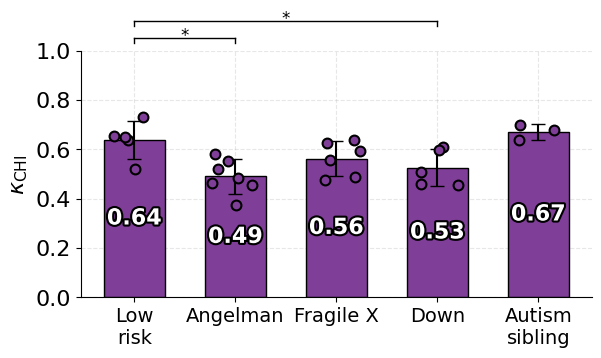

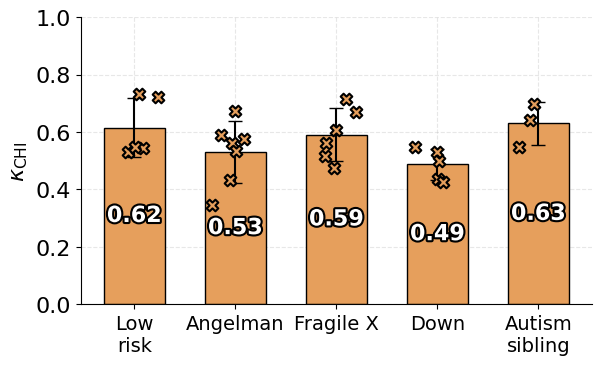

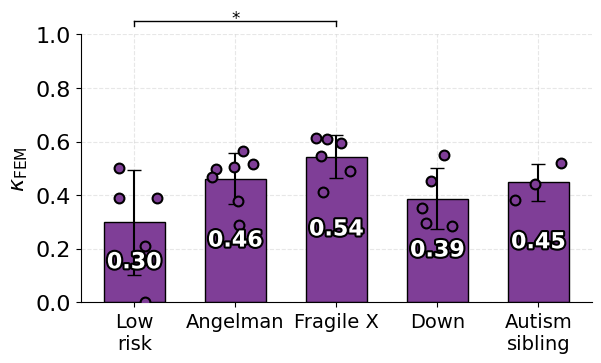

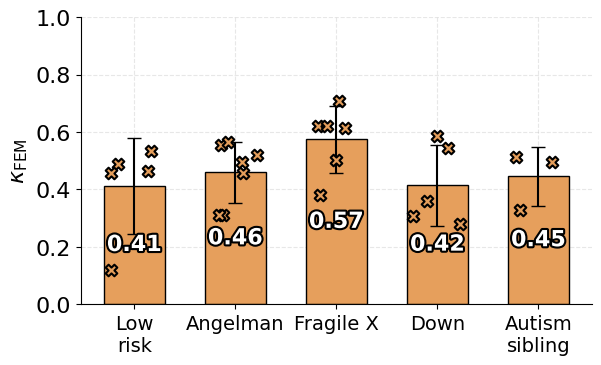

In [12]:
from scipy import stats

matplotlib.rcParams.update({
        'font.size': 16, 
        'legend.handleheight': 1,
        'hatch.linewidth': 1.0,
        'lines.markersize': 10, 
        'lines.linewidth': 2,
        'errorbar.capsize': 5,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16
    })

def add_group_significance_bars(ax, df, groups, col):
    def get_stars(p_value):
        if p_value < 0.001:
            return '***'
        elif p_value < 0.01:
            return '**'
        elif p_value < 0.05:
            return '*'
        return ''
    
    # Get y-axis range
    ymin, ymax = ax.get_ylim()
    ydist = ymax - ymin
    
    # Calculate relative spacings
    stars_spacing = 0.01 * ydist  # Space between bar and stars
    bar_spacing = 0.07 * ydist    # Space between multiple bars
    tick_height = 0.02 * ydist    # Length of vertical ticks
    base_height = ymax + (0.05 * ydist)  # Starting height above plot
    
    # Perform statistical tests against low_risk group
    control_group = 'low_risk'
    control_data = df[df['group_id'] == control_group][col]
    
    # Calculate spacing in axes coordinates
    trans = ax.transAxes.inverted()
    x_positions = range(len(groups))
    
    sig_count = 0
    
    for i, group in enumerate(groups[1:], 1):
        if group in df['group_id'].unique():
            test_data = df[df['group_id'] == group][col]
            
            # Perform Mann-Whitney U test
            statistic, p_value = stats.mannwhitneyu(
                control_data, 
                test_data,
                alternative='two-sided'
            )
            
            # Only add bars for significant results
            stars = get_stars(p_value)
            if stars:
                current_height = base_height + (sig_count * bar_spacing)
                sig_count += 1
                
                # Draw the bar
                ax.plot(
                    [0, i],
                    [current_height, current_height],
                    'k-',
                    linewidth=1,
                    transform=ax.transData,
                    clip_on=False
                )
                
                # Add vertical ticks
                ax.plot(
                    [0, 0],
                    [current_height - tick_height, current_height],
                    'k-',
                    linewidth=1,
                    clip_on=False
                )
                ax.plot(
                    [i, i],
                    [current_height - tick_height, current_height],
                    'k-',
                    linewidth=1,
                    clip_on=False
                )
                
                # Add stars
                ax.text(
                    (0 + i) / 2,
                    current_height + stars_spacing,  # Using relative spacing
                    stars,
                    ha='center',
                    va='center',
                    fontsize=12,
                    clip_on=False
                )
    
    # Maintain original y-axis limits
    ax.set_ylim(ymin, ymax)
    ax.set_clip_on(False)
    
def plot_kappa_by_group(df, color, marker, cat='CHI'):
    if cat not in ['CHI', 'FEM', 'MAL', 'OCH']:
        raise ValueError("cat must be either 'CHI' or 'FEM'")
        
    kappa_col = f'kappa_{cat}'
    
    jitter_width = 0.25
    alpha = 1
    size = 50
    if marker == 'X':
        size = 70
    cm = 1/2.54
    
    label_name = {
        'low_risk': 'Low\nrisk',
        'angelman_syndrome': 'Angelman',
        'fragile_x_syndrome': 'Fragile X',
        'down_syndrome': 'Down',
        'autism_sibling': 'Autism\nsibling'
    }
    
    groups = list(label_name.keys())
    available_groups = df['group_id'].unique()
    
    # Calculate statistics
    means = df.groupby('group_id')[kappa_col].mean().reindex(groups, fill_value=0)
    stds = df.groupby('group_id')[kappa_col].std().reindex(groups, fill_value=0)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(16*cm, 10*cm))
    
    x = np.arange(len(groups))
    width = 0.6
    
    # Create bars
    bars = ax.bar(x, means, width,
                 yerr=stds,
                 color=color,
                 alpha=alpha,
                 zorder=2,
                 edgecolor='black',
                 error_kw=dict(ecolor='black', elinewidth=1.5, capsize=5, capthick=1))
    
    # Add individual points
    for i, group in enumerate(groups):
        if group in available_groups:
            group_data = df[df['group_id'] == group][kappa_col]
            jitter = np.random.uniform(-jitter_width, jitter_width, size=len(group_data))
            ax.scatter(x[i] + jitter, group_data, 
                      color=color,
                      edgecolor='black',
                      s=size,
                      marker=marker,
                      linewidth=1.5,
                      zorder=3)
    
    # Add value labels in middle of bars
    for i, mean_val in enumerate(means):
        if mean_val > 0:  # Only add label if there's a bar
            # Position text at half the bar height
            y_pos = mean_val / 2
            
            text = ax.text(i, y_pos, 
                    f'{mean_val:.2f}',
                    ha='center',
                    va='center',
                    color='white',
                    weight='bold',
                    zorder=3,
                    size=16)
            text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])
    
    # Customize plot
    ax.set_ylabel(r'$\kappa_{\text{' + cat + '}}$')
    ax.set_ylim(0, 1.0)
    ax.set_xticks(x)
    ax.set_xticklabels([label_name[g] for g in groups], rotation=0, fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.3, zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    add_group_significance_bars(ax, df, groups, kappa_col)
    plt.tight_layout()    
    return fig, ax

plot_kappa_by_group(kappa_lena, color=lena_color, marker='o', cat='CHI')
plt.savefig('/home/engaclew/neurogen/figures/30mn_group/lena_kappa_CHI.png', dpi=300)
plt.show()
plot_kappa_by_group(kappa_vtc, color=aclew_color, marker='X', cat='CHI')
plt.savefig('/home/engaclew/neurogen/figures/30mn_group/vtc_kappa_CHI.png', dpi=300)
plt.show()
plot_kappa_by_group(kappa_lena, color=lena_color, marker='o', cat='FEM')
plt.savefig('/home/engaclew/neurogen/figures/30mn_group/lena_kappa_FEM.png', dpi=300)
plt.show()
plot_kappa_by_group(kappa_vtc, color=aclew_color, marker='X', cat='FEM')
plt.savefig('/home/engaclew/neurogen/figures/30mn_group/vtc_kappa_FEM.png', dpi=300)
plt.show()

/tmp/ipykernel_20058/2201680128.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby('group_id')[fscore_col].mean().reindex(groups, fill_value=0)
/tmp/ipykernel_20058/2201680128.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = df.groupby('group_id')[fscore_col].std().reindex(groups, fill_value=0)


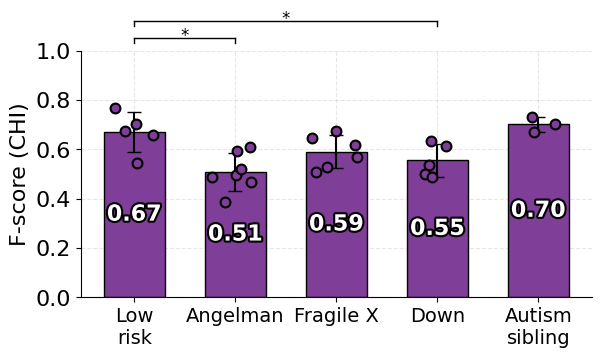

/tmp/ipykernel_20058/2201680128.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby('group_id')[fscore_col].mean().reindex(groups, fill_value=0)
/tmp/ipykernel_20058/2201680128.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = df.groupby('group_id')[fscore_col].std().reindex(groups, fill_value=0)


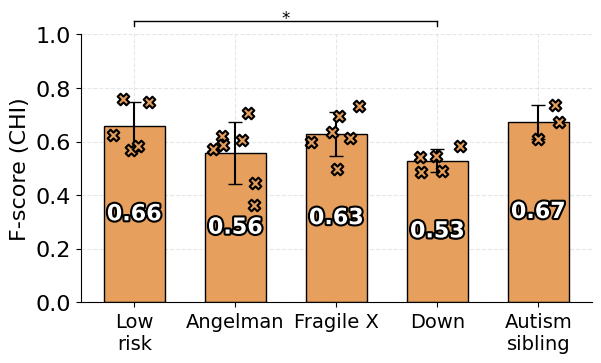

/tmp/ipykernel_20058/2201680128.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby('group_id')[fscore_col].mean().reindex(groups, fill_value=0)
/tmp/ipykernel_20058/2201680128.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = df.groupby('group_id')[fscore_col].std().reindex(groups, fill_value=0)


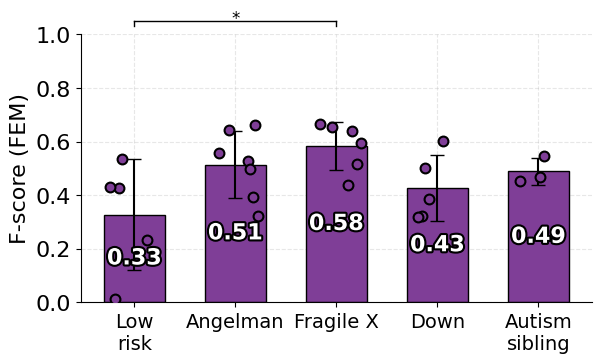

/tmp/ipykernel_20058/2201680128.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby('group_id')[fscore_col].mean().reindex(groups, fill_value=0)
/tmp/ipykernel_20058/2201680128.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = df.groupby('group_id')[fscore_col].std().reindex(groups, fill_value=0)


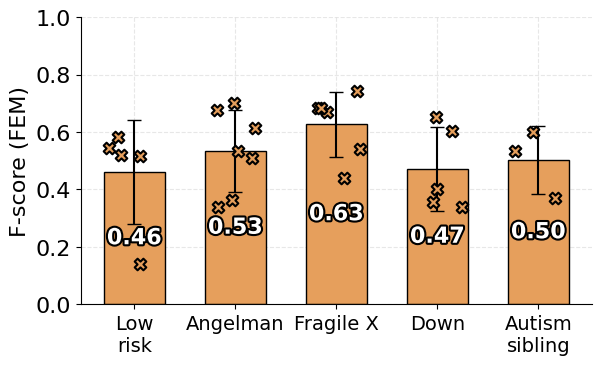

In [13]:
def plot_fscore_by_group(df, color, marker, cat='CHI'):
    if cat not in ['CHI', 'FEM', 'MAL', 'OCH']:
        raise ValueError("cat must be either 'CHI' or 'FEM'")
        
    fscore_col = f'fscore_{cat}'
    
    jitter_width = 0.25
    alpha = 1
    size = 50
    if marker == 'X':
        size = 70
    cm = 1/2.54
    
    label_name = {
        'low_risk': 'Low\nrisk',
        'angelman_syndrome': 'Angelman',
        'fragile_x_syndrome': 'Fragile X',
        'down_syndrome': 'Down',
        'autism_sibling': 'Autism\nsibling'
    }
    
    groups = list(label_name.keys())
    available_groups = df['group_id'].unique()
    
    # Calculate statistics
    means = df.groupby('group_id')[fscore_col].mean().reindex(groups, fill_value=0)
    stds = df.groupby('group_id')[fscore_col].std().reindex(groups, fill_value=0)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(16*cm, 10*cm))
    
    x = np.arange(len(groups))
    width = 0.6
    
    # Create bars
    bars = ax.bar(x, means, width,
                 yerr=stds,
                 color=color,
                 alpha=alpha,
                 zorder=2,
                 edgecolor='black',
                 error_kw=dict(ecolor='black', elinewidth=1.5, capsize=5, capthick=1))
    
    # Add individual points
    for i, group in enumerate(groups):
        if group in available_groups:
            group_data = df[df['group_id'] == group][fscore_col]
            jitter = np.random.uniform(-jitter_width, jitter_width, size=len(group_data))
            ax.scatter(x[i] + jitter, group_data, 
                      color=color,
                      edgecolor='black',
                      s=size,
                      marker=marker,
                      linewidth=1.5,
                      zorder=3)
    
    # Add value labels in middle of bars
    for i, mean_val in enumerate(means):
        if mean_val > 0:  # Only add label if there's a bar
            # Position text at half the bar height
            y_pos = mean_val / 2
            
            text = ax.text(i, y_pos, 
                    f'{mean_val:.2f}',
                    ha='center',
                    va='center',
                    color='white',
                    weight='bold',
                    zorder=3,
                    size=16)
            text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])
    
    # Customize plot
    ax.set_ylabel(f'F-score ({cat})')  # Changed from kappa to F-score
    ax.set_ylim(0, 1.0)
    ax.set_xticks(x)
    ax.set_xticklabels([label_name[g] for g in groups], rotation=0, fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.3, zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    add_group_significance_bars(ax, df, groups, fscore_col)
    plt.tight_layout()
    return fig, ax

plot_fscore_by_group(fscore_lena, color=lena_color, marker='o', cat='CHI')
plt.savefig('/home/engaclew/neurogen/figures/30mn_group/lena_fscore_CHI.png', dpi=300)
plt.show()
plot_fscore_by_group(fscore_vtc, color=aclew_color, marker='X', cat='CHI')
plt.savefig('/home/engaclew/neurogen/figures/30mn_group/vtc_fscore_CHI.png', dpi=300)
plt.show()
plot_fscore_by_group(fscore_lena, color=lena_color, marker='o', cat='FEM')
plt.savefig('/home/engaclew/neurogen/figures/30mn_group/lena_fscore_FEM.png', dpi=300)
plt.show()
plot_fscore_by_group(fscore_vtc, color=aclew_color, marker='X', cat='FEM')
plt.savefig('/home/engaclew/neurogen/figures/30mn_group/vtc_fscore_FEM.png', dpi=300)
plt.show()

In [14]:
# Identification error rate
from pathlib import Path
import pandas as pd
import numpy as np
results_folder = Path('/home/engaclew/neurogen/results/pyannote_metrics')

# Load f-score
ider_lena = pd.read_csv(results_folder / 'its_eaf_an1' / 'ider_30mn_clips.csv')
ider_vtc = pd.read_csv(results_folder / 'vtc_eaf_an1' / 'ider_30mn_clips.csv')
# Order
desired_order = ['low_risk', 'angelman_syndrome', 'fragile_x_syndrome', 'down_syndrome', 'autism_sibling']
ider_lena['group_id'] = pd.Categorical(ider_lena['group_id'], categories=desired_order, ordered=True)
ider_vtc['group_id'] = pd.Categorical(ider_vtc['group_id'], categories=desired_order, ordered=True)
ider_lena = ider_lena.sort_values('group_id')
ider_vtc = ider_vtc.sort_values('group_id')

print('Computing on %d chunks' % len(fscore_lena))
def compute_ider(ider_data):
    cols = ['missed detection', 'false alarm', 'confusion', 'correct']
    for col in cols:
        ider_data[col] = 100*ider_data[col]/ider_data['total']
    ider_data['ider'] *= 100
    return ider_data

ider_lena = compute_ider(ider_lena)
ider_vtc = compute_ider(ider_vtc)
ider_lena

Computing on 26 chunks


,recording_id,group_id,missed detection,total,confusion,correct,false alarm,ider
12,20180808_111213_024881.wav,low_risk,50.565152,219410.0,17.478237,31.956611,19.541042,87.584431
20,20180809_181624_025481.wav,low_risk,44.290436,611728.0,11.907416,43.802147,10.323052,66.520905
18,20220711_142955_024883_2.wav,low_risk,63.753398,207476.0,7.060576,29.186026,16.289595,87.103569
17,20190618_135122_024883.wav,low_risk,39.166806,388025.0,10.353457,50.479737,5.817151,55.337414
25,20220726_115556_024883_2.wav,low_risk,37.780748,374802.0,8.586934,53.632318,14.399870,60.767552
0,20190828_145547_024884_2.wav,angelman_syndrome,33.724225,490588.0,11.166396,55.109379,22.191533,67.082154
8,20210127_103244_024879_1.wav,angelman_syndrome,57.567478,372938.0,7.748473,34.684049,29.273767,94.589717
9,20181218_132113_024879.wav,angelman_syndrome,29.388044,466700.0,13.021213,57.590744,17.723163,60.132419
11,20230228_124411_043305_2.wav,angelman_syndrome,55.250826,120143.0,11.739344,33.009830,16.577745,83.567915
24,20211019_120823_045733_2.wav,angelman_syndrome,50.844310,236939.0,13.451563,35.704126,17.730724,82.026598


/tmp/ipykernel_20058/2559040420.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max1 = df1.groupby('group_id')[metric_col].mean().max() + df1.groupby('group_id')[metric_col].std().max()
/tmp/ipykernel_20058/2559040420.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max2 = df2.groupby('group_id')[metric_col].mean().max() + df2.groupby('group_id')[metric_col].std().max()
/tmp/ipykernel_20058/2559040420.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fut

(0, 25.088831848019662)


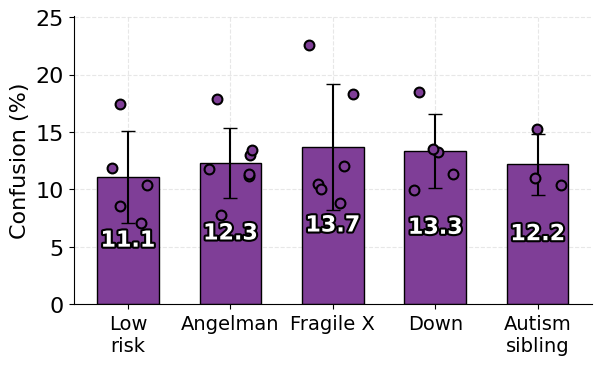

/tmp/ipykernel_20058/2559040420.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby('group_id')[metric_col].mean().reindex(groups, fill_value=0)
/tmp/ipykernel_20058/2559040420.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = df.groupby('group_id')[metric_col].std().reindex(groups, fill_value=0)


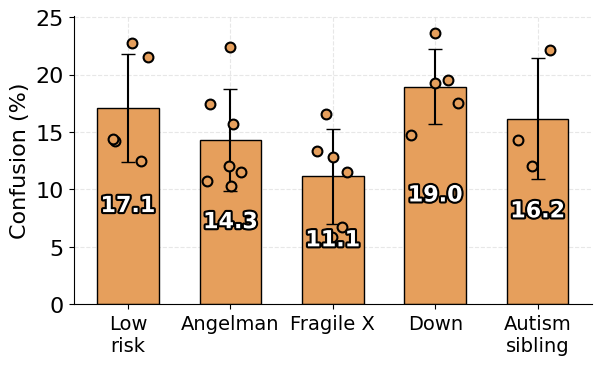

/tmp/ipykernel_20058/2559040420.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max1 = df1.groupby('group_id')[metric_col].mean().max() + df1.groupby('group_id')[metric_col].std().max()
/tmp/ipykernel_20058/2559040420.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max2 = df2.groupby('group_id')[metric_col].mean().max() + df2.groupby('group_id')[metric_col].std().max()
/tmp/ipykernel_20058/2559040420.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fut

(0, 149.9038548218703)


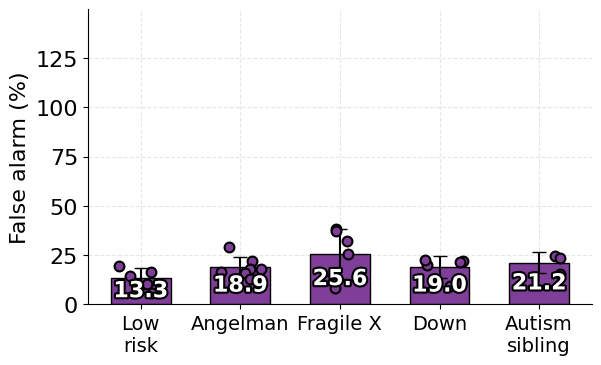

/tmp/ipykernel_20058/2559040420.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby('group_id')[metric_col].mean().reindex(groups, fill_value=0)
/tmp/ipykernel_20058/2559040420.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = df.groupby('group_id')[metric_col].std().reindex(groups, fill_value=0)


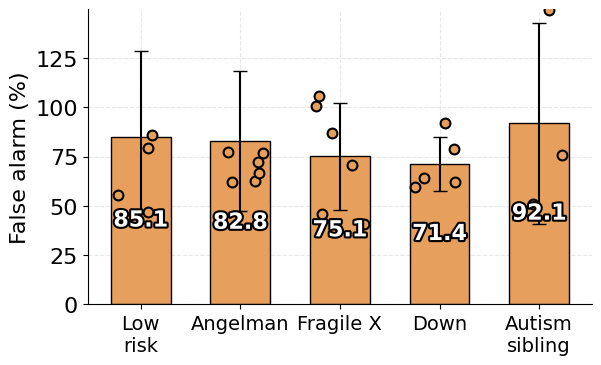

/tmp/ipykernel_20058/2559040420.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max1 = df1.groupby('group_id')[metric_col].mean().max() + df1.groupby('group_id')[metric_col].std().max()
/tmp/ipykernel_20058/2559040420.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max2 = df2.groupby('group_id')[metric_col].mean().max() + df2.groupby('group_id')[metric_col].std().max()
/tmp/ipykernel_20058/2559040420.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fut

(0, 60.846695710637746)


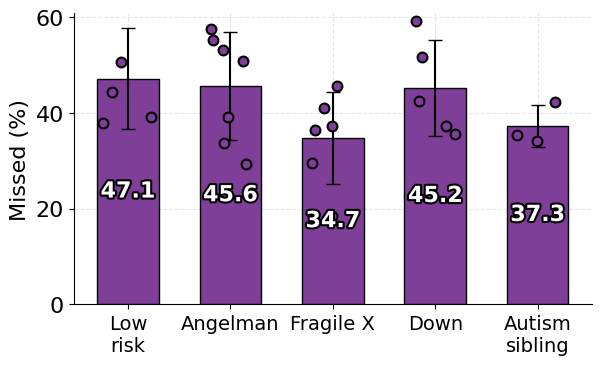

/tmp/ipykernel_20058/2559040420.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby('group_id')[metric_col].mean().reindex(groups, fill_value=0)
/tmp/ipykernel_20058/2559040420.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = df.groupby('group_id')[metric_col].std().reindex(groups, fill_value=0)


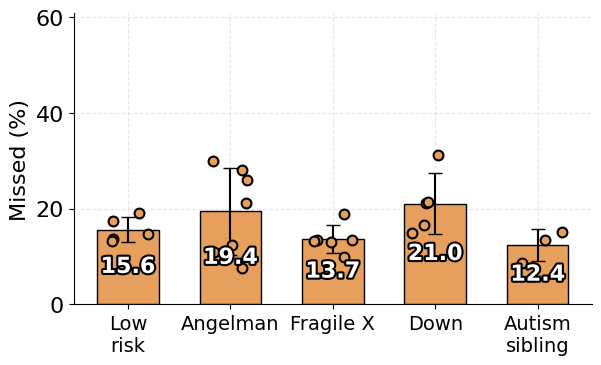

/tmp/ipykernel_20058/2559040420.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max1 = df1.groupby('group_id')[metric_col].mean().max() + df1.groupby('group_id')[metric_col].std().max()
/tmp/ipykernel_20058/2559040420.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max2 = df2.groupby('group_id')[metric_col].mean().max() + df2.groupby('group_id')[metric_col].std().max()
/tmp/ipykernel_20058/2559040420.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fut

(0, 89.13998538761237)


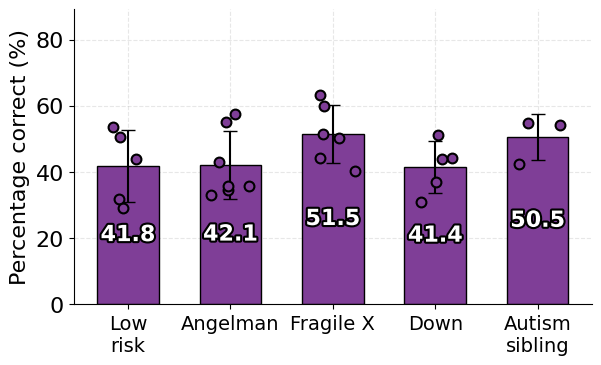

/tmp/ipykernel_20058/2559040420.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby('group_id')[metric_col].mean().reindex(groups, fill_value=0)
/tmp/ipykernel_20058/2559040420.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = df.groupby('group_id')[metric_col].std().reindex(groups, fill_value=0)


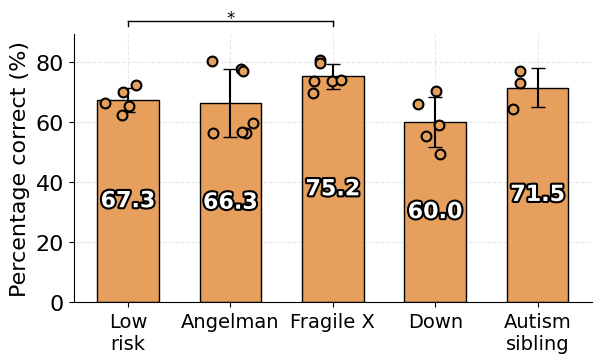

In [19]:
def get_metric_limits(df1, df2, metric_col):
    """Calculate the y-axis limits for a given metric across two datasets"""
    # Get maximum of means + stds for both datasets
    max1 = df1.groupby('group_id')[metric_col].mean().max() + df1.groupby('group_id')[metric_col].std().max()
    max2 = df2.groupby('group_id')[metric_col].mean().max() + df2.groupby('group_id')[metric_col].std().max()
    
    # Get minimum of means - stds for both datasets
    min1 = df1.groupby('group_id')[metric_col].mean().min() - df1.groupby('group_id')[metric_col].std().min()
    min2 = df2.groupby('group_id')[metric_col].mean().min() - df2.groupby('group_id')[metric_col].std().min()
    
    # Use the overall min and max
    ymin = min(min1, min2)
    ymax = max(max1, max2)
    
    # Add some padding (5% of the range)
    padding = (ymax - ymin) * 0.05
    return 0, ymax + padding

def plot_metric_by_group(df, color, marker, metric_col, ylim=None):
    jitter_width = 0.25
    alpha = 1
    size = 50
    if marker == 'X':
        size = 70
    cm = 1/2.54
    
    label_name = {
        'low_risk': 'Low\nrisk',
        'angelman_syndrome': 'Angelman',
        'fragile_x_syndrome': 'Fragile X',
        'down_syndrome': 'Down',
        'autism_sibling': 'Autism\nsibling'
    }

    metric_name = {
        'confusion': 'Confusion (%)',
        'false alarm': 'False alarm (%)',
        'missed detection': 'Missed (%)',
        'correct': 'Percentage correct (%)',
    }
    
    groups = list(label_name.keys())
    available_groups = df['group_id'].unique()
    
    # Calculate statistics
    means = df.groupby('group_id')[metric_col].mean().reindex(groups, fill_value=0)
    stds = df.groupby('group_id')[metric_col].std().reindex(groups, fill_value=0)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(16*cm, 10*cm))
    
    x = np.arange(len(groups))
    width = 0.6
    
    # Create bars
    bars = ax.bar(x, means, width,
                 yerr=stds,
                 color=color,
                 alpha=alpha,
                 zorder=2,
                 edgecolor='black',
                 error_kw=dict(ecolor='black', elinewidth=1.5, capsize=5, capthick=1))
    
    # Add individual points
    for i, group in enumerate(groups):
        if group in available_groups:
            group_data = df[df['group_id'] == group][metric_col]
            jitter = np.random.uniform(-jitter_width, jitter_width, size=len(group_data))
            ax.scatter(x[i] + jitter, group_data, 
                      color=color,
                      edgecolor='black',
                      s=size,
                      marker=marker,
                      linewidth=1.5,
                      zorder=3)
    
    # Add value labels in middle of bars
    for i, mean_val in enumerate(means):
        if mean_val > 0:  # Only add label if there's a bar
            # Position text at half the bar height
            y_pos = mean_val / 2
            
            text = ax.text(i, y_pos, 
                    f'{mean_val:.1f}',
                    ha='center',
                    va='center',
                    color='white',
                    weight='bold',
                    zorder=3,
                    size=16)
            text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])
    
    # Customize plot
    ax.set_ylabel(metric_name[metric_col])
    ax.set_xticks(x)
    ax.set_xticklabels([label_name[g] for g in groups], rotation=0, fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.3, zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set y-axis limits if provided
    if ylim is not None:
        ax.set_ylim(ylim)
    
    add_group_significance_bars(ax, df, groups, metric_col)
    plt.tight_layout()
    return fig, ax

# Usage for each metric:
metrics = ['confusion', 'false alarm', 'missed detection', 'correct']

for metric in metrics:
    # Get common y-axis limits for this metric
    ylim = get_metric_limits(ider_lena, ider_vtc, metric)
    print(ylim)
    # Plot LENA
    plot_metric_by_group(ider_lena, color=lena_color, marker='o', metric_col=metric, ylim=ylim)
    plt.savefig(f'/home/engaclew/neurogen/figures/30mn_group/lena_{metric.replace(" ", "_")}.png', dpi=300)
    plt.show()
    
    # Plot ACLEW
    plot_metric_by_group(ider_vtc, color=aclew_color, marker='o', metric_col=metric, ylim=ylim)
    plt.savefig(f'/home/engaclew/neurogen/figures/30mn_group/aclew_{metric.replace(" ", "_")}.png', dpi=300)
    plt.show()